In [1]:
!pip3 install tokenizers matplotlib numpy pylzma ipykernel jupyter torch

In [2]:
import torch, torch.nn as nn
from torch.nn import functional as F
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from tokenizers.normalizers import Lowercase, NFD, StripAccents
from tokenizers.pre_tokenizers import Whitespace
import math
import matplotlib.pyplot as plt
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
block_size=126 # sequence length
batch_size=256
max_iters=1000
eval_iters=100
show_iters=50
lr=3e-5
n_embd=256 # total no of dimensons we want to capture
n_layer=4 # no of decoder blocks
n_head=4 # no of heads running in parallel
dropout=0.4 # dropping out these many neurons to prevent overfitting
wt_decay=0.1

In [4]:
class Head(nn.Module):
    """Single self-attention head computing scaled dot-product attention with masking."""
    def __init__(self,head_size):
        """Initializes key, query, value projections and dropout for a single attention head."""
        super().__init__()
        self.key=nn.Linear(n_embd,head_size,bias=False)
        self.query=nn.Linear(n_embd,head_size,bias=False)
        self.value=nn.Linear(n_embd,head_size,bias=False)
        #self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size))) #registers no look ahead masking in model state, saves computation overhead
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        """Performs scaled dot-product self-attention with causal masking and returns attended values."""
        B,T,C=x.shape #(batch, time-step and channels)
        k=self.key(x) #(B,T,head_size)
        q=self.query(x) #(B,T,head_size)
        wei=q@k.transpose(-2,-1)*(k.shape[-1]**(-0.5)) # (B,T,h_s)@(B,h_s,T)=(B,T,T) dot product keys and queries and scaled by 1/sqrt(len of row in k)
        tril = torch.tril(torch.ones(T, T, device=x.device))
        #wei=wei.masked_fill(self.tril[:T,:T]==0,float('-inf')) #(B,T,T) exponention done as we are doing softmax in next step
        wei=wei.masked_fill(tril==0,float('-inf'))
        wei=F.softmax(wei,dim=-1) #(B,T,T) highlights attention scores for more important tokens
        wei=self.dropout(wei)
        v=self.value(x) #(B,T,h_s)
        out=wei@v #multiplying value with output of softmax
        return out
    
class MultiHeadAttention(nn.Module):
    """Combines n_heads attention heads and projects the concatenated output."""
    def __init__(self,num_heads,head_size):
        """Initializes multiple attention heads and final linear projection layer."""
        super().__init__()
        self.heads=nn.ModuleList([Head(head_size) for _ in range(num_heads)]) #creates num_heads heads running in parallel
        self.proj=nn.Linear(head_size*num_heads,n_embd) # adds more learnable parameters that helps network learn about text
        self.dropout=nn.Dropout(dropout)

    def forward(self,x):
        """Concatenates outputs from all heads, applies projection and dropout."""
        out=torch.cat([h.forward(x) for h in self.heads],dim=-1) #(B,T,F) -> (B,T,[h1,h1,h1,h1,h2,h2,h2,h2,h3,h3,h3,h3]) concatenate along last dim i.e. F
        out=self.dropout(self.proj(out))
        return out
    
class FeedForward(nn.Module):
    """Two-layer feedforward neural network with ReLU and dropout for non-linearity and regularization."""
    def __init__(self,n_embd):
        """Creates a two-layer feedforward network with ReLU activation and dropout."""
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(n_embd,4*n_embd),
            nn.ReLU(), # max(0,x)
            nn.Linear(4*n_embd,n_embd),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        """Applies feedforward transformation to the input."""
        return self.net(x)
    
class Block(nn.Module):
    """Transformer decoder block with attention, feedforward, and layer normalization."""
    def __init__(self,n_embd,n_head):
        """Initializes a transformer decoder block with multi-head attention, feedforward, and layer norms."""
        super().__init__()
        head_size=n_embd//n_head  #no of features each head captures in multihead attention
        self.sa=MultiHeadAttention(n_head,head_size)
        self.ffwd=FeedForward(n_embd)
        self.ln1=nn.LayerNorm(n_embd)
        self.ln2=nn.LayerNorm(n_embd)

    def forward(self,x):
        """Applies self-attention and feedforward layers with residual connections and layer normalization."""
        #Post Norm Architecture
        y=self.sa(x) # 1. Self attention
        x=self.ln1(x+y) #2. Add & norm
        y=self.ffwd(x) #3. FeedForward
        x=self.ln2(x+y) #4. Add & norm
        return x
    
class GPTLangModel(nn.Module):
    """GPT-style language model with stacked decoder blocks, embeddings, and final output projection."""
    def __init__(self,vocab_size):
        """Initializes the full GPT language model including embeddings, transformer blocks, and output head."""
        super().__init__()
        self.token_embedding_table=nn.Embedding(vocab_size,n_embd)
        self.position_embedding_table=nn.Embedding(block_size,n_embd) #positional encoding
        self.blocks=nn.Sequential(*[Block(n_embd,n_head=n_head) for _ in range(n_layer)]) #decoder layers
        self.ln_f=nn.LayerNorm(n_embd) #final layer norm at end of newtwork
        self.lm_head=nn.Linear(n_embd,vocab_size) #language modelling head final linear layer transformation

        self.apply(self._init_weights)

    def _init_weights(self,module):
        """Custom weight initialization for Linear and Embedding layers using a normal distribution."""
        if isinstance(module,nn.Linear):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module,nn.Embedding):
            torch.nn.init.normal_(module.weight,mean=0.0,std=0.02)


    def forward(self,index,targets=None):
        """Computes token embeddings, applies transformer blocks, and returns logits and optional loss."""
        #logits=self.token_embedding_table(index)
        #B,T,C=logits.shape
        B,T=index.shape

        tok_emb=self.token_embedding_table(index)
        pos_emd=self.position_embedding_table(torch.arange(T,device=device))
        x=tok_emb+pos_emd
        x=self.blocks(x)
        x=self.ln_f(x)
        logits=self.lm_head(x)
        if targets is None:
            loss=None
        else:
            B,T,C=logits.shape
            logits=logits.view(B*T,C)
            targets=targets.view(B*T)
            loss=F.cross_entropy(logits,targets)

        return logits,loss

    def generate(self,index,max_new_tokens):
        """Generates new tokens from an initial context using autoregressive decoding.""""
        for _ in range(max_new_tokens):
            logits,loss=self.forward(index)
            logits=logits[:,-1,:]
            probs=F.softmax(logits,dim=-1)
            index_next=torch.multinomial(probs,num_samples=1)
            index=torch.cat((index,index_next),dim=1)
            if index.shape[1] > block_size:
                index = index[:, -block_size:]

        return index

In [5]:
def get_batch(split):
    """Fetches a random batch of input and target sequences from train or validation data."""
    if split=='train':
        data=train_data
    else:
        data=val_data
    ix=torch.randint(len(data)-block_size,(batch_size,))
    x=torch.stack([data[i:i+block_size] for i in ix])
    y=torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y=x.to(device),y.to(device)
    return x,y

In [6]:
@torch.no_grad() #torch should not use graident here
def estimate_loss():
    """Estimates average loss and perplexity for train and validation sets without computing gradients."""
    out={}
    model.eval()
    for split in ['train','val']:
        losses=torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,Y=get_batch(split)
            logits,loss=model(X,Y)
            losses[k]=loss.item()
        avg_loss = losses.mean().item()
        perplexity = math.exp(avg_loss)
        out[split] = {
            'loss': avg_loss,
            'perplexity': perplexity
        }
    model.train()
    return out

In [7]:
def train():
  """Main training loop that updates model weights, logs loss/perplexity, and plots training curves."""
  train_losses = []
  val_losses = []
  iters=[]
  # BLEU/perplexity score
  optimizer=torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=wt_decay)

  for iter in range(max_iters):
      if iter%eval_iters==0:
          metrics = estimate_loss()
          train_losses.append(metrics['train']['loss'])
          val_losses.append(metrics['val']['loss'])
          iters.append(iter)
          if(iter%show_iters==0):
            print(f"Step {iter}, train loss: {metrics['train']['loss']:.3f}, val loss: {metrics['val']['loss']:.3f} | train ppl: {metrics['train']['perplexity']:.2f}, val ppl: {metrics['val']['perplexity']:.2f}")
      xb,yb=get_batch('train')
      logits,loss=model.forward(xb,yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()
  print(f"Final training loss after {max_iters} iterations: {loss.item():.4f}")
  plt.figure(figsize=(8, 6))
  plt.plot(iters, train_losses, label='Train Loss', color='blue', marker='o')
  plt.plot(iters, val_losses, label='Validation Loss', color='orange', marker='x')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss vs Iteration')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# I. CHARACTER LEVEL TOKENIZATION

Breaks text down into individual characters. Each character becomes a token.

In [8]:
chars=""
with open('frankenstein.txt','r',encoding='UTF-8') as f:
    text=f.read()
    chars=sorted(set(text))

vocab_size_char=len(chars)

str_to_int={ch:i for i,ch in enumerate(chars)}
int_to_str={i:ch for i,ch in enumerate(chars)}
encode=lambda s: [str_to_int[c] for c in s]
decode=lambda l: ''.join([int_to_str[i] for i in l])

data=torch.tensor(encode(text),dtype=torch.long)

n=int(0.75*len(data))
train_data=data[:n]
val_data=data[n:]

In [9]:
model=GPTLangModel(vocab_size_char)
m=model.to(device)
context=torch.zeros((1,1),dtype=torch.long,device=device)
gen_chars=decode(m.generate(context,max_new_tokens=50)[0].tolist())
print(gen_chars)


OT3S”KkuôB
ôBa2sF6e)?RkFêP;wx0PUH m‘E]O”oIiê;a(yBN


For character level tokenization we get: 
Step 0, train loss: 4.484, val loss: 4.481 | train ppl: 88.60, val ppl: 88.32
Step 100, train loss: 3.025, val loss: 3.020 | train ppl: 20.58, val ppl: 20.50
Step 200, train loss: 2.695, val loss: 2.688 | train ppl: 14.80, val ppl: 14.70
Step 300, train loss: 2.589, val loss: 2.579 | train ppl: 13.32, val ppl: 13.19
Step 400, train loss: 2.533, val loss: 2.523 | train ppl: 12.59, val ppl: 12.46
Step 500, train loss: 2.498, val loss: 2.489 | train ppl: 12.16, val ppl: 12.05
Step 600, train loss: 2.477, val loss: 2.466 | train ppl: 11.91, val ppl: 11.77
Step 700, train loss: 2.458, val loss: 2.449 | train ppl: 11.68, val ppl: 11.57
Step 800, train loss: 2.442, val loss: 2.433 | train ppl: 11.50, val ppl: 11.40
Step 900, train loss: 2.426, val loss: 2.417 | train ppl: 11.31, val ppl: 11.21
Final training loss after 1000 iterations: 2.4439


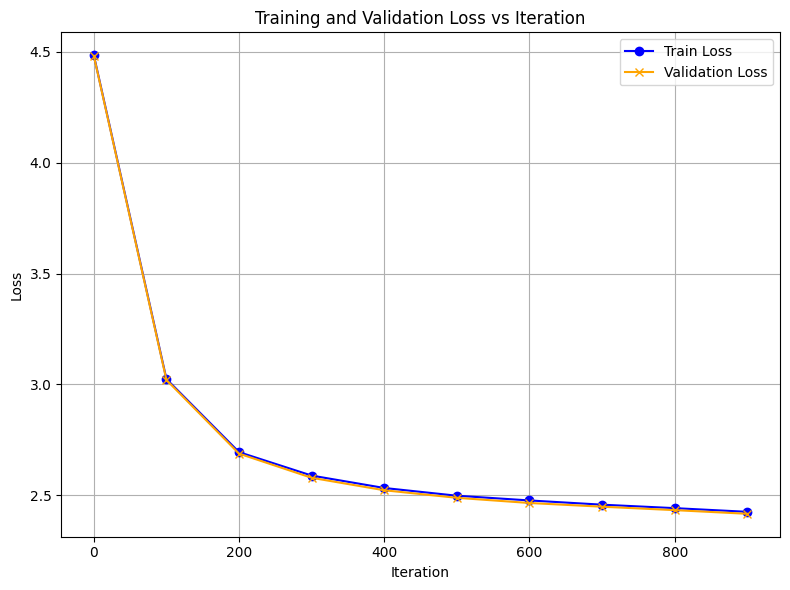

In [10]:
print("For character level tokenization we get: ")
train()

In [11]:
seed_text = "monster"
context = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
gen_chars = decode(m.generate(context, max_new_tokens=20)[0].tolist())
print("For character level tokenization, output text for input = 'monster' is: ",gen_chars)

For character level tokenization, output text for input = 'monster' is:  monster aret matily bier ai


In [12]:
del model
torch.cuda.empty_cache()

# II. BYTE-PAIR ENCODING (BPE) TOKENIZATION

Starts with characters, then iteratively merges most frequent pairs into new tokens. Balances between character-level and word-level. Used in GPT, GPT-2, RoBERTa, BART, and DeBERTa.

In [13]:
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(special_tokens=["<PAD>", "<UNK>"], vocab_size=5000)

with open("frankenstein.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    text = ''.join(lines)

tokenizer.train_from_iterator(lines, trainer=trainer)

vocab_size_bpe = tokenizer.get_vocab_size()
encode = lambda s: tokenizer.encode(s).ids
decode = lambda l: tokenizer.decode(l)

data = torch.tensor(encode(text), dtype=torch.long)

n=int(0.75*len(data))
train_data=data[:n]
val_data=data[n:]

In [14]:
model=GPTLangModel(vocab_size_bpe)
m=model.to(device)
context=torch.zeros((1,1),dtype=torch.long,device=device)
gen_chars=decode(m.generate(context,max_new_tokens=10)[0].tolist())
print(gen_chars)

owe endowed malice unfortunately ould enveloped ke beauty cursor cottage


For Byte-Pair Encoding (BPE) tokenization we get: 
Step 0, train loss: 8.575, val loss: 8.577 | train ppl: 5295.35, val ppl: 5310.76
Step 100, train loss: 7.296, val loss: 7.311 | train ppl: 1474.38, val ppl: 1496.45
Step 200, train loss: 6.722, val loss: 6.742 | train ppl: 830.29, val ppl: 847.60
Step 300, train loss: 6.367, val loss: 6.415 | train ppl: 582.04, val ppl: 611.22
Step 400, train loss: 6.061, val loss: 6.171 | train ppl: 428.86, val ppl: 478.62
Step 500, train loss: 5.762, val loss: 5.974 | train ppl: 317.95, val ppl: 392.93
Step 600, train loss: 5.524, val loss: 5.838 | train ppl: 250.53, val ppl: 343.08
Step 700, train loss: 5.333, val loss: 5.731 | train ppl: 207.12, val ppl: 308.37
Step 800, train loss: 5.174, val loss: 5.659 | train ppl: 176.68, val ppl: 286.74
Step 900, train loss: 5.032, val loss: 5.600 | train ppl: 153.22, val ppl: 270.54
Final training loss after 1000 iterations: 4.9554


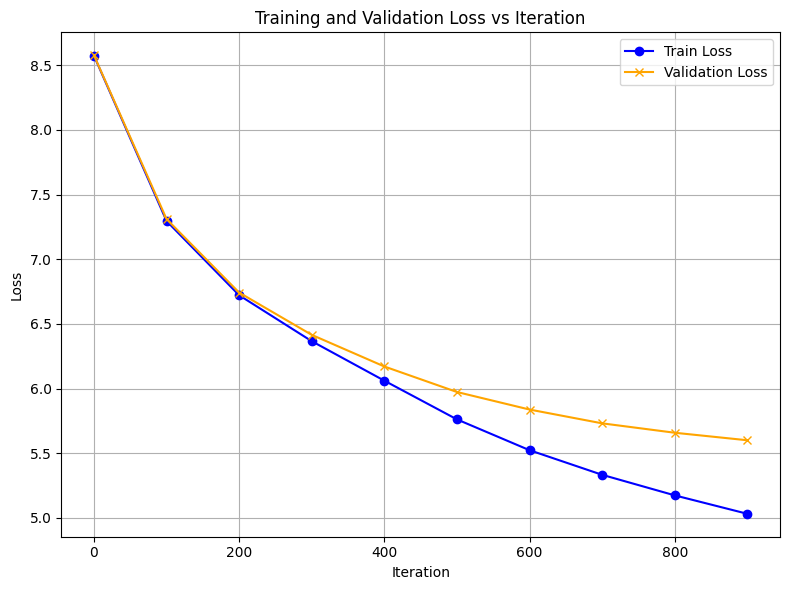

In [15]:
print("For Byte-Pair Encoding (BPE) tokenization we get: ")
train()

In [16]:
seed_text = "monster"
context = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
gen_chars = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print("For Byte-Pair encoding(BPE) tokenization, output text for input = 'monster' is: ",gen_chars)

For Byte-Pair encoding(BPE) tokenization, output text for input = 'monster' is:  monster ? shone in of the various continue fit orns steps


In [17]:
del model
torch.cuda.empty_cache()

# III. WORDPIECE TOKENIZATION

Similar to BPE but merges pairs based on likelihood of improving a language model, not just frequency. Focuses on maximizing likelihood rather than frequency alone. Google developed it to pretrain BERT. Used in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT, Funnel Transformers, and MPNET.

In [18]:
tokenizer_wp = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer_wp.normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
tokenizer_wp.pre_tokenizer = Whitespace()

trainer_wp = trainers.WordPieceTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"])

with open("frankenstein.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    text = ''.join(lines)

tokenizer_wp.train_from_iterator(lines, trainer=trainer_wp)

# Define encode/decode functions and vocab size
vocab_size_wp = tokenizer_wp.get_vocab_size()
encode = lambda s: tokenizer_wp.encode(s).ids
decode = lambda l: tokenizer_wp.decode(l)

# Encode the dataset
data = torch.tensor(encode(text), dtype=torch.long)

n=int(0.75*len(data))
train_data=data[:n]
val_data=data[n:]

In [19]:
model=GPTLangModel(vocab_size_wp)
m=model.to(device)
context=torch.zeros((1,1),dtype=torch.long,device=device)
gen_chars=decode(m.generate(context,max_new_tokens=10)[0].tolist())
print(gen_chars)

evening impr struct ##iating merely ##iff things sooner drawing horrors


For WordPiece tokenization we get: 
Step 0, train loss: 8.568, val loss: 8.568 | train ppl: 5260.34, val ppl: 5259.53
Step 100, train loss: 7.259, val loss: 7.271 | train ppl: 1420.80, val ppl: 1438.63
Step 200, train loss: 6.676, val loss: 6.689 | train ppl: 793.06, val ppl: 803.87
Step 300, train loss: 6.325, val loss: 6.367 | train ppl: 558.21, val ppl: 582.59
Step 400, train loss: 6.045, val loss: 6.136 | train ppl: 421.79, val ppl: 462.13
Step 500, train loss: 5.743, val loss: 5.928 | train ppl: 312.09, val ppl: 375.44
Step 600, train loss: 5.497, val loss: 5.783 | train ppl: 244.02, val ppl: 324.85
Step 700, train loss: 5.303, val loss: 5.678 | train ppl: 200.89, val ppl: 292.36
Step 800, train loss: 5.140, val loss: 5.604 | train ppl: 170.74, val ppl: 271.42
Step 900, train loss: 5.000, val loss: 5.545 | train ppl: 148.41, val ppl: 256.06
Final training loss after 1000 iterations: 4.9430


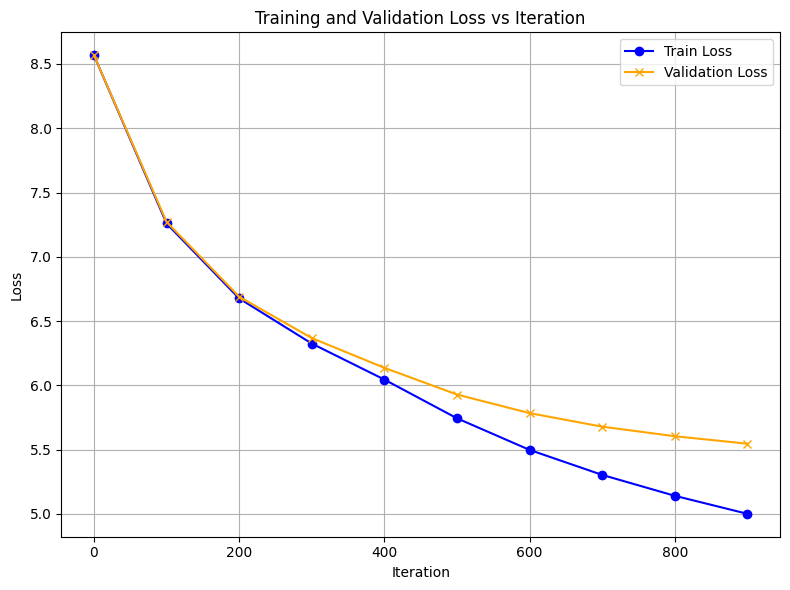

In [20]:
print("For WordPiece tokenization we get: ")
train()

In [21]:
seed_text = "monster"
context = torch.tensor([encode(seed_text)], dtype=torch.long, device=device)
gen_chars = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print("For WordPiece tokenization, output text for input = 'monster' is: ",gen_chars)

For WordPiece tokenization, output text for input = 'monster' is:  monster pardon me ##ness that i shall inc bounds a div


In [22]:
del model
torch.cuda.empty_cache()